In [15]:
# pip install pandasql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandasql import sqldf

## 1 Overviews

### 1.1 Tables
#### 1.1.1 yammer_emails

In [18]:
emails = pd.read_csv('yammer_emails.csv')
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


#### 1.1.2 yammer_users

In [20]:
users = pd.read_csv('yammer_users.csv')
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


#### 1.1.3 yammer_events

In [189]:
events = pd.DataFrame()
for i in range(1, 4):
    df = pd.read_csv('yammer_events%d.csv' % i)
    events = pd.concat([events, df], ignore_index = True)

print(len(events))
events.tail()

340832


,user_id,occurred_at,event_type,event_name,location,device,user_type
340827,18815.0,2014-08-31 13:41:46,engagement,like_message,Ireland,dell inspiron notebook,2.0
340828,18815.0,2014-08-31 13:42:11,engagement,home_page,Ireland,dell inspiron notebook,2.0
340829,18815.0,2014-08-31 13:42:43,engagement,send_message,Ireland,dell inspiron notebook,2.0
340830,18815.0,2014-08-31 13:43:07,engagement,home_page,Ireland,dell inspiron notebook,2.0
340831,18815.0,2014-08-31 13:43:42,engagement,like_message,Ireland,dell inspiron notebook,2.0


### 1.2 Problem Description
Assumes that today is __September 2, 2014.__. You walk in the office, open the engagement dashboard, check out the data performance as usual, the below chart came up.

The chart shows the number of engaged users in recent weeks. You notice that there is a drop since the middle of July, and a much huge drop at the beginning of August. Thus, you are responsible for determining what caused the dip at the chart, and recommending solutions for the problem.

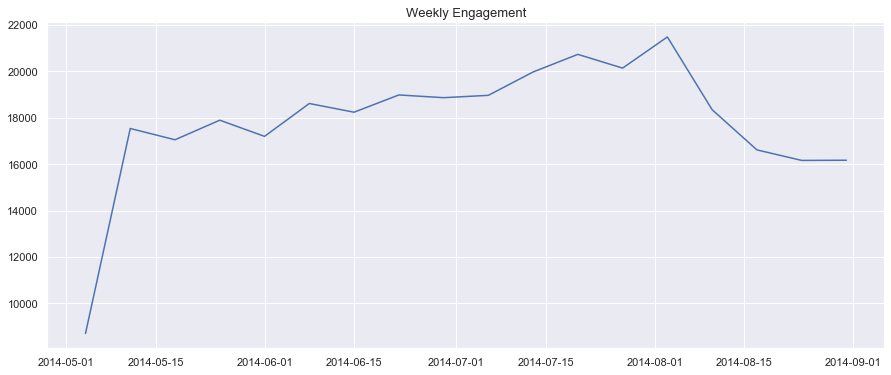

In [548]:
engagement = events[events['event_type'] == 'engagement'].copy()
engagement['occurred_at'] = pd.to_datetime(engagement['occurred_at'])
dt_str = engagement['occurred_at'].apply(lambda x: datetime.datetime.strftime(x,"%Y-%m-%d"))
engagement['date'] = dt_str
engagement = engagement.set_index('date')
grouped = pd.DataFrame(engagement.groupby(['date']).size())
grouped.index = pd.to_datetime(grouped.index)
weekly_engagement_sum = grouped.resample('w').sum()

sns.set(style="darkgrid")
fig = plt.figure(figsize = (15, 6));
plt.plot(weekly_engagement_sum.index, weekly_engagement_sum[0]);
plt.title('Weekly Engagement', fontsize = 13);

## 2 Analysis

We can seperate the issue into small pieces.

- Time
- Devices
- Broken Features
- Region

### 2.1 Time
The time issue is the most important metric for us to learn about, there're a few possibilities for us to investigate. 

__Is the drop of engagement a sudden one or a gradual one?__

From the observed weekly engagement chart, it's easily seen that the weekly engagement steadily increase from May to July, but gradually drop from the middle of July. Thus, we should think about more on the changes on user behavior.

__Is there specific time worth noticing on users engagement?__

We could also identify whether there are special days within that period of time, such as holidays or weekends. If there's no big difference suddenly occured, then we can rule out the possibility that the special days impacted our user engagement.

#### 2.1.1 Monthly Drop
First of all, let's gather the __events__ data together, and see the total loss of engagement. Compared with engagement number of 9,1830 at July, we loss 1,8037 engagement in August. Which is quite a large number.

In [332]:
# helper function that executes the sql query
pysqldf = lambda sql : sqldf(sql, globals())

In [132]:
sql = '''
SELECT a.*, 
       a.count - b.count AS diff
  FROM (SELECT CAST(strftime('%m', occurred_at) AS INT) AS month,
               COUNT(event_name) AS count
            FROM events
           WHERE event_type = "engagement"
           GROUP BY month) AS a
  LEFT JOIN (SELECT CAST(strftime('%m', occurred_at) AS INT) AS month,
                    COUNT(event_name) AS count
            FROM events
           WHERE event_type = "engagement"
           GROUP BY month) AS b
    ON a.month = b.month + 1;
'''
SQL = pysqldf(sql)
SQL

,month,count,diff
0,5,77646,NaN
1,6,78306,660.0
2,7,91830,13524.0
3,8,73793,-18037.0


#### 2.1.2 Daily Engagement

Except for the monthly summary, we can analyze __is the drop a one-time occurrence or a recurring one__ by looking at how the number behave on a daily basis.

If the drop in this time span only occurs once, we should consider a technical issue such as the change on our UI, or the update of the version etc.

When gathering the daily engagement and plot that out, I found the number fluctuates every day. While __this fluctuation repeats regularly__, even after the total monthly drops. We are confident that __the recurring is due to some behaviour change__.

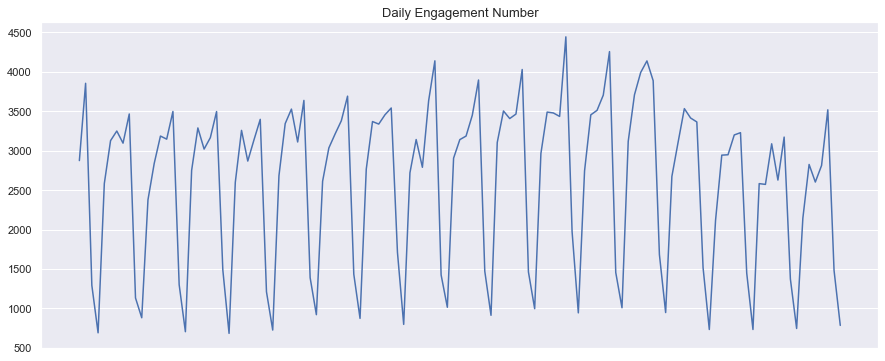

In [549]:
sql = '''
SELECT strftime('%Y-%m-%d', occurred_at) AS date,
       COUNT(event_name) AS count
  FROM events
 WHERE event_type = "engagement"
 GROUP BY date'''
SQL = pysqldf(sql)

sns.set(style="darkgrid")
fig = plt.figure(figsize = (15, 6));
plt.plot(SQL['date'], SQL['count'])
plt.xticks([])
plt.title('Daily Engagement Number', fontsize = 13);

#### 2.1.3 Weekly Engagement
After dividing the weekly data into seven days, I found that users use Yammer less on Saturday and Sunday. 

Since Yammer is designed for communication with coworkers, less engagement during the weekends seems reseanable.

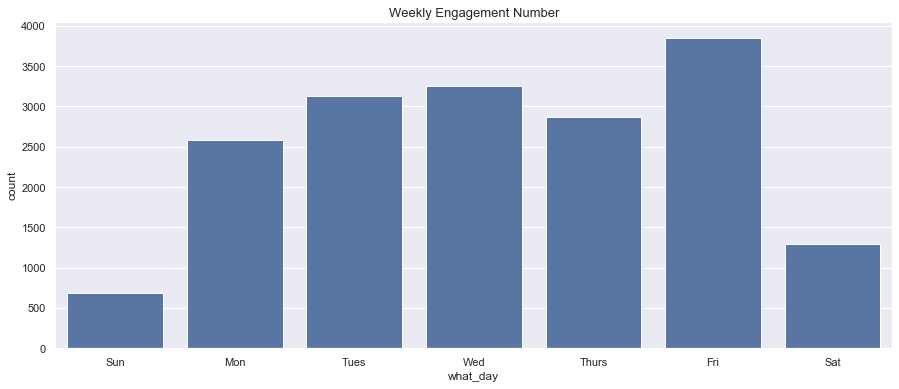

In [546]:
sql = '''
SELECT strftime('%w', a.Date) AS days_in_week,
       CASE WHEN CAST(strftime('%w', a.Date) AS INT) = 0 THEN "Sun"
            WHEN CAST(strftime('%w', a.Date) AS INT) = 1 THEN "Mon"
            WHEN CAST(strftime('%w', a.Date) AS INT) = 2 THEN "Tues"
            WHEN CAST(strftime('%w', a.Date) AS INT) = 3 THEN "Wed"
            WHEN CAST(strftime('%w', a.Date) AS INT) = 4 THEN "Thurs"
            WHEN CAST(strftime('%w', a.Date) AS INT) = 5 THEN "Fri"
            WHEN CAST(strftime('%w', a.Date) AS INT) = 6 THEN "Sat" END AS what_day,
       a.count
  FROM (SELECT strftime('%Y-%m-%d', occurred_at) as Date, COUNT(event_name) AS count
          FROM events
         WHERE event_type = "engagement"
         GROUP BY date) AS a
 GROUP BY days_in_week, what_day
 ORDER BY days_in_week;
'''
SQL = pysqldf(sql)
SQL

sns.set(style="darkgrid")
fig = plt.figure(figsize = (15, 6));
sns.barplot(x = 'what_day', y = 'count', data = SQL, color = 'b')
plt.title('Weekly Engagement Number', fontsize = 13);

So far, I identify no special cases happen during that time that worth noticing. 

When rule out the time influences, I can further investigate whether the problem derives from our product, such as changing features, refresh failure, market competition etc.

### 2.2 Platform

The first technical issue I would like to address is about platform. The interfaces and functions on different devices vary a lot. Users preferences and behaviors on using different platforms might vary, too.

__Is there a decline happens in specific platforms, rather than all platforms?__

If we see a decline only occurs in some kinds of platforms, then we need to consider the problem might come from that certain platform.

I divide those devices into 3 groups: mobile, tablet, computer.

In [223]:
events['device'].unique()

array(['dell inspiron notebook', 'iphone 5', 'iphone 4s',
       'windows surface', 'macbook air', 'iphone 5s', 'macbook pro',
       'kindle fire', 'ipad mini', 'nexus 7', 'nexus 5',
       'samsung galaxy s4', 'lenovo thinkpad', 'samsumg galaxy tablet',
       'acer aspire notebook', 'asus chromebook', 'htc one',
       'nokia lumia 635', 'samsung galaxy note', 'acer aspire desktop',
       'mac mini', 'hp pavilion desktop', 'dell inspiron desktop',
       'ipad air', 'amazon fire phone', 'nexus 10'], dtype=object)

We observed obvious drops at mobile and computer platforms, which are 39.3% and 28.9% respectively. 

The engagement of mobile droped 39.37084257206209 percent.
The engagement of computer droped 28.90127388535032 percent.


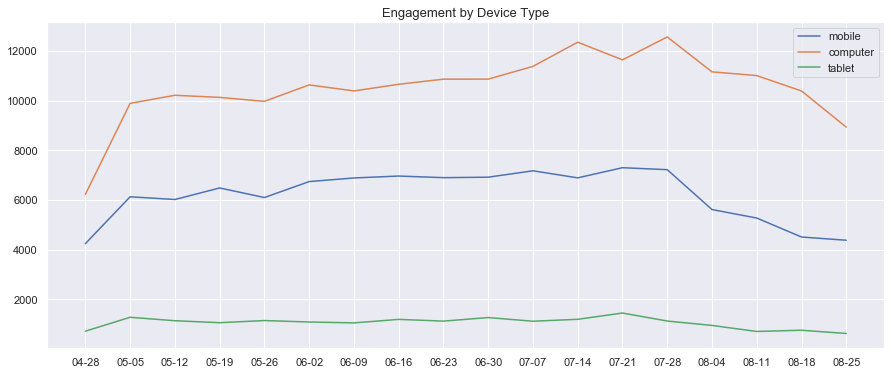

In [545]:
sql = '''
SELECT strftime('%m-%d', occurred_at, 'weekday 1', '-7 days') as week,
       CASE WHEN device IN ('amazon fire phone', 'nexus 10', 'iphone 5', 'nexus 7', 'iphone 5s', 'nexus 5', 'htc one', 'iphone 4s', 'samsung galaxy note', 'nokia lumia 635', 'samsung galaxy s4') THEN 'mobile'
            WHEN device IN ('ipad mini', 'samsung galaxy tablet', 'kindle fire', 'ipad air') THEN 'tablet'
            WHEN device IN ('dell inspiron desktop', 'macbook pro', 'asus chromebook', 'windows surface', 'macbook air', 'lenovo thinkpad', 'mac mini', 'acer aspire desktop', 'acer aspire notebook', 'dell inspiron notebook', 'hp pavilion desktop') THEN 'computer'
            ELSE null END AS platform,
        COUNT(event_name) AS count
  FROM events
 WHERE event_type = 'engagement'
 GROUP BY week, platform;
'''

SQL = pysqldf(sql)

mobile_drop = (SQL[(SQL.week == '08-25') & (SQL.platform == 'mobile')]['count'].values - SQL[(SQL.week == '07-28') & (SQL.platform == 'mobile')]['count'].values) / SQL[(SQL.week == '07-28')  & (SQL.platform == 'mobile')]['count'].values
comp_drop = (SQL[(SQL.week == '08-25') & (SQL.platform == 'computer')]['count'].values - SQL[(SQL.week == '07-28') & (SQL.platform == 'computer')]['count'].values) / SQL[(SQL.week == '07-28')  & (SQL.platform == 'computer')]['count'].values
print("The engagement of mobile droped", np.abs(mobile_drop[0]) * 100, "percent.")
print("The engagement of computer droped", np.abs(comp_drop[0]) * 100, "percent.")

f, ax = plt.subplots(figsize=(15, 6));
for device in ('mobile', 'computer', 'tablet'):
    device_change = SQL[SQL['platform'] == device].copy()
    plt.plot(device_change['week'], device_change['count'], label = device);
    plt.legend();
plt.title('Engagement by Device Type', fontsize = 13);


These are pretty significance number, especially for mobile platform, the drop is about a half. Therefore, we need to identify __what caused the engagement drops in these platforms__.

### 2.3 Email Activities

In [254]:
# the email actions 
actions = emails['action'].unique()
print(actions)

['sent_weekly_digest' 'email_open' 'email_clickthrough'
 'sent_reengagement_email']


In [385]:
sql = '''
SELECT e1.action,
        (e2.count2 - e1.count1) / CAST(e1.count1 AS double) AS rate_of_change
  FROM (SELECT CAST(strftime('%m', occurred_at) AS INT) AS month,
               action,
               COUNT(action) AS count1
          FROM emails
         GROUP BY month, action
        HAVING month = 7) AS e1
   LEFT JOIN (SELECT CAST(strftime('%m', occurred_at) AS INT) AS month,
                     action,
                     COUNT(action) AS count2
                FROM emails
               GROUP BY month, action
              HAVING month = 8) AS e2
    ON e1.action = e2.action
'''
SQL = pysqldf(sql)
SQL

,action,rate_of_change
0,email_clickthrough,-0.267916
1,email_open,0.065407
2,sent_reengagement_email,0.150054
3,sent_weekly_digest,0.036348


Under the __action__ category, there're 4 types of email actions. From the above code, I've calculated the rate of change by each category from July to August. And I noticed that only the email_clickthrough droped. It declined about 27%, which is a significant number we should pay attention to.

Since the __action__ is a sequence behavior, that is, receiving weekly_digest email, opening email, click link in email to look inside content. And there's another action that reengage the email subscription. 

We can dig further and seperate it into two parts:
- by __email types__: Weekly digest emails and re-subscriped emails
- by __actions__: email opens and email click-throughs

#### 2.3.1 Click-Through-Rate by Devices
Since I've found out that the engagement drop mostly on mobile and computer, and since users can only click in the link when they open the emails. While the number of emailes being opened is steady increasing, I'd like to check the click-through across various platforms. Here on the below chart, I also see an evident drop in mobile and computer, which matches our previous engagement trends. 

This is very resonable. Since mobile and computer users take up the majority of the traffic while only small amount of users are using tablet to surf in Yammer. 

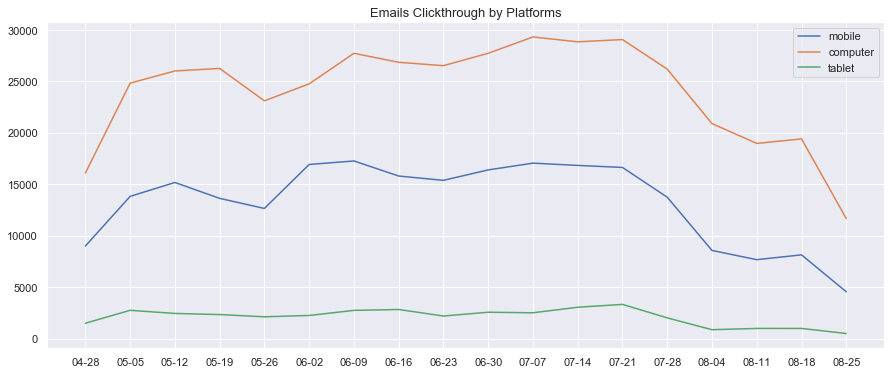

In [551]:
sql = '''
SELECT strftime('%m-%d', em.occurred_at, 'weekday 1', '-7 days') as week,
       CASE WHEN ev.device IN ('amazon fire phone', 'nexus 10', 'iphone 5', 'nexus 7', 'iphone 5s', 'nexus 5', 'htc one', 'iphone 4s', 'samsung galaxy note', 'nokia lumia 635', 'samsung galaxy s4') THEN 'mobile'
            WHEN ev.device IN ('ipad mini', 'samsung galaxy tablet', 'kindle fire', 'ipad air') THEN 'tablet'
            WHEN ev.device IN ('dell inspiron desktop', 'macbook pro', 'asus chromebook', 'windows surface', 'macbook air', 'lenovo thinkpad', 'mac mini', 'acer aspire desktop', 'acer aspire notebook', 'dell inspiron notebook', 'hp pavilion desktop') THEN 'computer'
            ELSE null END AS platform,
       COUNT(ev.event_name) AS count
  FROM emails em
  LEFT JOIN events ev
    ON em.user_id = ev.user_id
 WHERE ev.event_type = 'engagement'
   AND em.action = 'email_clickthrough'
 GROUP BY week, platform;
'''
SQL = pysqldf(sql)

f, ax = plt.subplots(figsize=(15, 6));
for device in ('mobile', 'computer', 'tablet'):
    device_ctr = SQL[SQL['platform'] == device].copy()
    plt.plot(device_ctr['week'], device_ctr['count'], label = device);
    plt.legend();
plt.title('Emails Clickthrough by Platforms', fontsize = 13);

#### 2.3.2 Actions vs Email types
Later, I investigate how users behave when they receive different types of emails.

From the figure below, the click-through on weekly digest drops tremendously from July to August, while other indexs remain steady increase. Therefore, the drop on clicks was due to less clicking on weekly digest.

Since the click-through of weekly-digest isn't drop down to 0, so I can rule out the possibility that this is a tecnical clicking or refresh failure issue. Thus, I assume that this might be a reason that __users found the content in weekly digest unattractive or irrelavent__. 

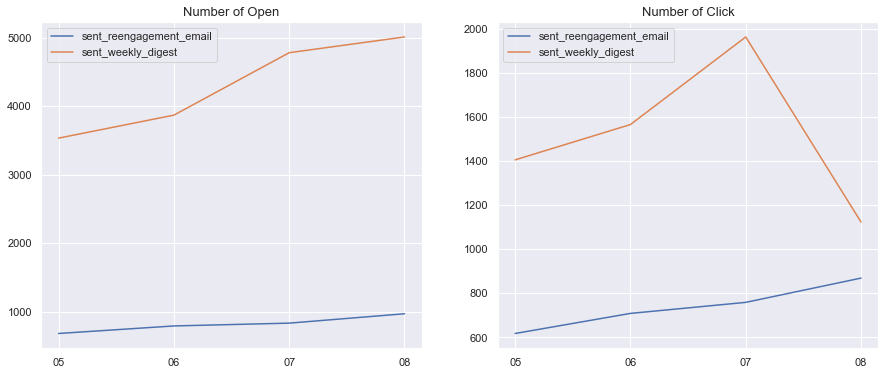

In [552]:
sql = '''
with one as(
SELECT *, 
       strftime('%m', occurred_at) as month,
       CASE WHEN (LEAD(action, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) = 'email_open' THEN 1 ELSE 0 END AS opened_email,
       CASE WHEN (LEAD(action, 2) OVER (PARTITION BY user_id ORDER BY occurred_at)) = 'email_clickthrough' THEN 1 ELSE 0 END AS clicked_email
  FROM emails
)
SELECT action, 
       month, 
       SUM(opened_email) AS num_open,
       SUM(clicked_email) AS num_clicked
  FROM one
 WHERE action IN ('sent_weekly_digest', 'sent_reengagement_email')
 GROUP BY action, month
 ORDER BY action, month;
'''
SQL = pysqldf(sql)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
for act in ('sent_reengagement_email', 'sent_weekly_digest'):
    type_ = SQL[SQL['action'] == act].copy()
    ax1.plot(type_['month'], type_['num_open'], label = act);
    ax1.legend(loc = 'upper left')
    ax1.set_title('Number of Open', fontsize=13)
    ax2.plot(type_['month'], type_['num_clicked'], label = act);
    ax2.legend(loc = 'upper left')
    ax2.set_title('Number of Click', fontsize=13)

### 2.4 Event Type

#### 2.4.1 General Events Analysis
Further, identify if there's certain event type or broken features in the website or app that cause the change. I first pick 5 most frequently used engagement events. Those are: home_page, like, view_inbox, login, send_message.

In [390]:
# most frequently used events
sql = '''
SELECT event_name,
       COUNT(event_name) as count
  FROM events
 WHERE event_type = 'engagement'
 GROUP BY event_name
 ORDER BY count DESC
 LIMIT 5;
'''
top_events = pysqldf(sql)
top_5_events = list(top_events['event_name'])
top_events

,event_name,count
0,home_page,94065
1,like_message,59248
2,view_inbox,55936
3,login,38610
4,send_message,33105


After plot the trends, alomost all of the events are seeing a drop. Of all the drops, I found that the home_page visit declines most obviously, which affacts other engagement activities in some ways.

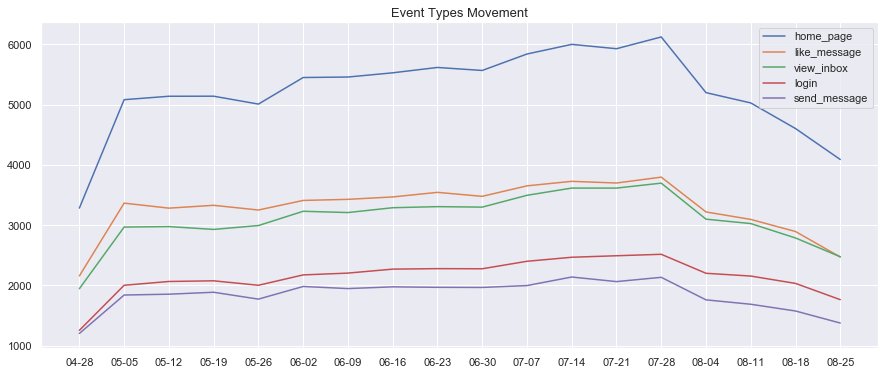

In [555]:
sql = '''
SELECT strftime('%m-%d', occurred_at, 'weekday 1', '-7 days') as week, 
       event_name,
       COUNT(event_name) AS count
  FROM events
 WHERE event_type = 'engagement'
 GROUP BY week, event_name;
'''
SQL = pysqldf(sql)


f, ax = plt.subplots(figsize=(15, 6));
for type_ in top_5_events:
    event = SQL[SQL['event_name'] == type_].copy()
    plt.plot(event['week'], event['count'], label = type_);
    plt.legend();
plt.title('Event Types Movement', fontsize = 13);

#### 2.4.2 Event Types by Devices
Later, I found that of all three types of divices, mobile and tablet drops more obvious than computer. We should consider the possibility that the problem might come from the function in the app.

In [480]:
sql = '''
WITH one AS(
SELECT CAST(strftime('%m', occurred_at) AS INT)  AS month, 
       event_name,
       CASE WHEN device IN ('amazon fire phone', 'nexus 10', 'iphone 5', 'nexus 7', 'iphone 5s', 'nexus 5', 'htc one', 'iphone 4s', 'samsung galaxy note', 'nokia lumia 635', 'samsung galaxy s4') THEN 'mobile'
            WHEN device IN ('ipad mini', 'samsung galaxy tablet', 'kindle fire', 'ipad air') THEN 'tablet'
            WHEN device IN ('dell inspiron desktop', 'macbook pro', 'asus chromebook', 'windows surface', 'macbook air', 'lenovo thinkpad', 'mac mini', 'acer aspire desktop', 'acer aspire notebook', 'dell inspiron notebook', 'hp pavilion desktop') THEN 'computer'
            ELSE null END AS platform,
       COUNT(event_name) AS count
  FROM events
 WHERE event_type = 'engagement'
   AND event_name IN ('home_page', 'like_message', 'view_inbox', 'login', 'send_message')
   AND platform IS NOT NULL
 GROUP BY month, event_name, platform
)
SELECT t2.month, t2.event_name, t2.platform,
       (t2.count - t1.count) / CAST(t1.count AS DOUBLE) AS rate_of_change
  FROM one AS t1
  LEFT JOIN one AS t2
    ON t1.event_name = t2.event_name
   AND t1.platform = t2.platform
   AND t1.month = t2.month - 1
 WHERE t2.month = 8;
'''
SQL = pysqldf(sql)
SQL

,month,event_name,platform,rate_of_change
0,8,home_page,computer,-0.104459
1,8,home_page,mobile,-0.302549
2,8,home_page,tablet,-0.361468
3,8,like_message,computer,-0.119055
4,8,like_message,mobile,-0.296195
5,8,like_message,tablet,-0.406988
6,8,login,computer,-0.051461
7,8,login,mobile,-0.295300
8,8,login,tablet,-0.347953
9,8,send_message,computer,-0.140444


### 2.5 Users - tracking the user retention

Next, we can analyze our __users__, consider whether the lower engagement might due to lossing users. 

#### 2.5.1 General User Analysis
I first cumulatively identify the change of the active users over time. It turns out that the __active user rates are stably remain around 0.5 every month__, and it is even showing a growing trend until August. Thus, __Yammer has no problem with retaining active users__.

On the other head, I found that __total users are generally in a growing trend__, except for some small fluctuations each month. Therefore, __we could consider the problem might be fail to retain old user__ and continue dig in further on it.

In [527]:
sql = '''
SELECT t1.year_month, t1.user_count, t2.active_user_count,
       SUM(t1.user_count) OVER (ORDER BY t1.year_month) AS user_sum,
       SUM(t2.active_user_count) OVER (ORDER BY t1.year_month) AS active_user_sum,
       SUM(t2.active_user_count) OVER (ORDER BY t1.year_month) / CAST(SUM(t1.user_count) OVER (ORDER BY t1.year_month) AS DOUBLE) AS active_user_rate
  FROM (SELECT strftime('%Y-%m', created_at, 'weekday 1', '-7 days') as year_month,
               COUNT(DISTINCT user_id) AS user_count
          FROM users
         GROUP BY year_month) AS t1
  JOIN (SELECT strftime('%Y-%m', created_at, 'weekday 1', '-7 days') as year_month,
                    COUNT(DISTINCT user_id) AS active_user_count
               FROM users
              WHERE state = 'active'
              GROUP BY year_month
               ) AS t2
    ON t1.year_month = t2.year_month
 WHERE t1.year_month IS NOT NULL;
'''
SQL = pysqldf(sql)
SQL.tail()

,year_month,user_count,active_user_count,user_sum,active_user_sum,active_user_rate
16,2014-04,1336,674,11997,5806,0.483954
17,2014-05,1460,718,13457,6524,0.484803
18,2014-06,2048,1042,15505,7566,0.487972
19,2014-07,1757,877,17262,8443,0.489109
20,2014-08,1804,938,19066,9381,0.492028


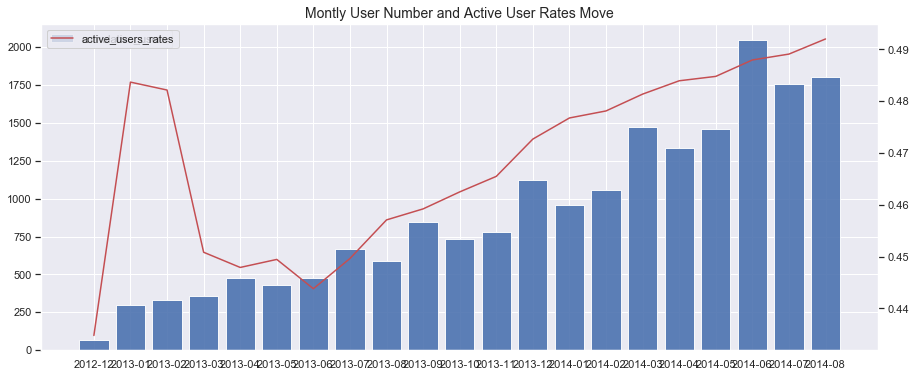

In [543]:
f, ax1 = plt.subplots(figsize=(15, 6));
ax1.bar(SQL['year_month'], SQL['user_count'], label = 'cumulative_users', alpha = 0.9);
ax1.legend();

ax2 = ax1.twinx()  
ax2.plot(SQL['year_month'], SQL['active_user_rate'], label = 'active_users_rates', color = 'r');
ax2.grid(False);
ax2.legend();

plt.title('Montly User Number and Active User Rates Move', fontsize = 14);

#### 2.5.2 Long Term User Analysis
Since I identify that there's no issue in growing new users or maintain active users, the problem might be that Yammer is unable to retain old users. Therefore, I seperate users into 9 groups according to the time they activated accounts to see the engagement changes on each groups of users, especially for long term users.

After check the retention of old users, it turns out that __the company is keep lossing long term users__. This cohort analysis helps to identify the product's long term effectiveness. From the figure below, we see that users are growing for a short term, but losing stickness in a long run. This is unlikely to be a technical issue, but should consider __product designs that let old users that felt less engaged__, or __other similar products in the market that users feel it more suitable and switch to that one__.

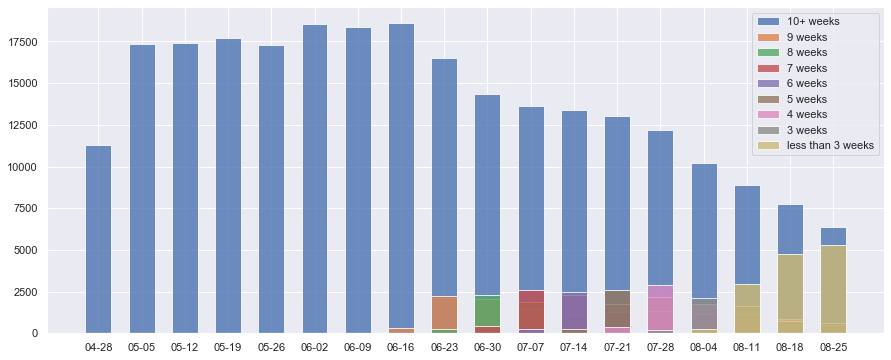

In [484]:
sql = '''
SELECT CASE WHEN activate_length > 70 THEN '10+ weeks'
            WHEN activate_length > 63 AND activate_length <= 70 THEN '9 weeks'
            WHEN activate_length > 56 AND activate_length <= 63 THEN '8 weeks'
            WHEN activate_length > 49 AND activate_length <= 56 THEN '7 weeks'
            WHEN activate_length > 42 AND activate_length <= 49 THEN '6 weeks'
            WHEN activate_length > 35 AND activate_length <= 42 THEN '5 weeks'
            WHEN activate_length > 28 AND activate_length <= 35 THEN '4 weeks'
            WHEN activate_length > 21 AND activate_length <= 28 THEN '3 weeks'
            WHEN activate_length <= 21 THEN 'less than 3 weeks' END AS user_ages,
       strftime('%m-%d', e.occurred_at, 'weekday 1', '-7 days') as week, 
       COUNT(u.user_id) as count
  FROM (SELECT *, 
               CAST((julianday('2014-09-02') - julianday(activated_at)) as INT) as activate_length
          FROM users) AS u
  LEFT JOIN events e
    ON u.user_id = e.user_id
 WHERE u.state = 'active'
   AND e.event_type = 'engagement'
 GROUP BY week, user_ages;
'''
SQL = pysqldf(sql)

ages = ['10+ weeks', '9 weeks', '8 weeks', '7 weeks', '6 weeks', '5 weeks', '4 weeks', '3 weeks', 'less than 3 weeks']
f, ax = plt.subplots(figsize=(15, 6));
for age in ages:
    age_atc = SQL[SQL['user_ages'] == age].copy()
    plt.bar(age_atc['week'], age_atc['count'], width = 0.6, alpha = 0.8, label = age);
    plt.legend();

###  2.6 Region
If we see a drop in engagement tied to a specific region or country would help us better identify the issue and fix that in terms of their user behaviors. Here I first select the top 5 countries that contribute most users, which are the US, Japan, Germany, France and UK. When analyze their engagement repectively, I found that __engagement of users from US drops the most__. With that in mind, we can investigate on US market in depth, for example, __are there any censorship  or laws which forbid users enthusiasm in using the app__, or __other similar products being released that are more close to Americans behavior__.  

In [213]:
# identify top 5 region
sql = '''
SELECT location,
       COUNT(event_name) AS count
  FROM events
 WHERE event_type = "engagement"
 GROUP BY location
 ORDER BY count DESC
 LIMIT 5;
'''

top_5_region = pysqldf(sql)
top_5_region = list(top_5_region['location'])
top_5_region

['United States', 'Japan', 'Germany', 'France', 'United Kingdom']

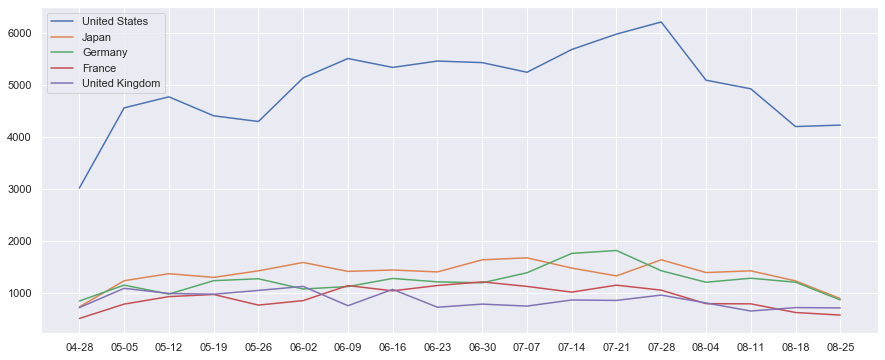

In [229]:
sql = '''
SELECT strftime('%m-%d', occurred_at, 'weekday 1', '-7 days') as week,
       location,
       COUNT(event_name) AS count
  FROM events
 WHERE event_type = "engagement"
   AND location IN ('United States',
                    'Japan',
                    'Germany',
                    'France',
                    'United Kingdom')
 GROUP BY week, location;
'''

SQL = pysqldf(sql)

f, ax = plt.subplots(figsize=(15, 6));
for region in top_5_region:
    region_change = SQL[SQL['location'] == region].copy()
    plt.plot(region_change['week'], region_change['count'], label = region);
    plt.legend();

## 3 Summary
According to my previous analysis, I could draw the following conclusions:
- There are no special cases that worth noticing from May to August of 2014, so we can rule out the possibility that some special time events happened and caused the drop in user engagements.


- When analyzing the behaviors of different platforms, the declines on mobile and computer are more obvious. Which I don't consider it tells much since most traffics come from mobile and computer, so I have to analyze specific actions on those devices to better analyze the engagements.


- First I analyze users behaves on their emails. By segmenting the emails' actions, I find that only the click-through drops from July to August while other indexes remain increasing. I further analyze email clickthroughs by each platform, the drop occured in mobile and computer, which corresponds to my previous engagement by platforms analysis. Finally, I analyze emails actions with respect to email types, and find out that the drop in clickthroughs was caused by weekly-digest emails. Therefore, it's reasonable to consider the problem might derive from the content of weekly-digest.


- Secondly, in order to identify whether there are broken features on the product, I look into the event types and it turns out that the homepage visits decreasing contributes to the decline. When group the event types by different devices, here I find users visit less homepage on mobiles and tablets. Here I think it's probably users felt unconvinient to look through the homepage website on their phones, but the conclusion is not persuasive enough.


- The users data provides many valuable information for us. The active and growing users show no special signs to us, but I find the long-term users are droping recently. We should figure out the reason why the product losses users' loyalty.


- Finally, an analysis toward users from different regions made me realize that the users from the US could be our priority of investigate.

## 4 Recommendation
So far for my anaysis, I would give the following recommendations:
- Check with the web developers to see if there was a change on softwares recently, especially changes not simultaneously launched across different platforms.


- Look into the weekly-digest emails, see if all the links work well and no technical bugs. And I would also recommend improving the content in the weekly-digest, because users less engagement might simply because they loss interests.


- Investigate on similar products within the ecosystem, especially the markets in the US. Compare our products with others, and see if there are major difference that cause US users less engaged.